In [1]:
import duckdb
import pandas

In [5]:
con = duckdb.connect("swiggy_reviews.duckdb")

In [7]:
con.execute("SHOW TABLES").df()

,name
0,reviews


In [8]:
con.execute("SELECT COUNT(*) AS total_reviews FROM reviews").df()

,total_reviews
0,260740


In [11]:
def get_daily_reviews(con, date: str) -> list[str]:
  df = con.execute(
    f"""
    SELECT review_text
    FROM reviews
    WHERE review_date = '{date}'
    """
  ).df()
  return df["review_text"].tolist()

In [13]:
test_review = get_daily_reviews(con, "2025-06-15")

In [14]:
len(test_review)

859

In [50]:
import random
random.choice(test_review)

'worest experience we ordered in swiggy that delivery partner took the food without accept he cancelled and we waited for food second partner told that that first partner took the food and gone . this is swiggy security system worst experience and customer support also waste.'

In [58]:
test_review[50:60]

['good',
 'good',
 'good',
 'nice work',
 'good',
 "worst conusmer support. i ordered something but it showed that it will take 65 minutes to deliver the order so i tried to cencel the order within a minute after ordering but the swiggy's consumer support says that they will take a fine amounted equal to the order i will cencel . so i didn't cancelled the order due to this .I am truly unsatisfied with the consumer support.🤬🤬",
 'nice',
 'very nice',
 'worst service',
 "Pls do not use this app, they're making fools of their premium customer and do not delivered the order on time and having everytime the same excuse in their chat box and no one cooperative with the customers"]

In [112]:
def batch_reviews(reviews, batch_size=20):
    for i in range(0, len(reviews), batch_size):
        yield reviews[i:i + batch_size]


In [113]:
from dotenv import load_dotenv

In [118]:
load_dotenv()

from openai import OpenAI
import ast

client = OpenAI()

def extract_issues_llm(review_batch):
    prompt = f"""
    You are an AI assistant helping analyze app reviews.

    Given a list of user reviews, extract ALL distinct issues, complaints, requests, or negative feedback mentioned.

    Rules:
    - Ignore reviews that only express praise, emojis, or vague positivity (e.g. "good", "nice", "🥰").
    - A single review may contain multiple issues — extract each separately.
    - Use short, clear, action-oriented phrases.
    - Do NOT merge similar issues.
    - Do NOT summarize.
    - Do NOT explain.
    - Output ONLY a Python list of strings.

    Reviews:
    {review_batch}
    """

    response = client.chat.completions.create(
        model="gpt-4o-mini",  # cost-efficient
        messages=[{"role": "user", "content": prompt}],
        temperature=0
    )
    raw_output = response.choices[0].message.content.strip()

    # Remove ```python or ``` if present
    if raw_output.startswith("```"):
        raw_output = raw_output.strip("`")
        raw_output = raw_output.replace("python", "", 1).strip()

    return ast.literal_eval(raw_output)


In [ ]:
sample_batch = test_review[:20]
issues = extract_issues_llm(sample_batch)

issues

['pathetic service',
 'delivered wrong order multiple times for same order',
 'Customer Care Service Very Bad',
 'Not Interested Swiggy Instamart App',
 'Very Sad For 1St Order Not A Replacement Product',
 'Very Bad Service',
 'Full Money West',
 'I Hate Swiggy Instamart App',
 'they charge separately for handling products',
 "still don't care about providing a paper bag",
 'products was not given in paper bag',
 'the way products were handed over was really disappointing',
 "you didn't give discount after selecting the paying method",
 'The order had not been placed but the amount had been deducted',
 'no response till date for refund',
 'galti se order ho jaye to cancel karne ka option nahi h',
 'next order pe cancelled order ki penalty dete h']

: 

In [102]:
from typing import TypedDict, List, Dict, Annotated
import operator

class AgentState(TypedDict):
  master_taxonomy: Annotated[List[str], operator.add]
  frequency_table: Dict[str, Dict[str, int]]
  current_batch: List[str]
  current_date: str
  latest_extracted_topics: List[str]
  daily_mapping: Dict[str, str]

In [103]:
initial_state = {
  "master_taxonomy": [],
  "frequency_table": {},
  "current_batch": [],
  "current_date": ""
}

In [65]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import SystemMessage, HumanMessage
import math
from dotenv import load_dotenv

In [66]:
load_dotenv()
llm = ChatOpenAI(model="gpt-4o", temperature=0)


In [100]:
import re

def extraction_node(state: AgentState):
    reviews = state["current_batch"]
    chunk_size = 50
    all_candidate_topics = []
    
    for i in range(0, len(reviews), chunk_size):
        chunk = reviews[i : i + chunk_size]
        chunk_text = "\n".join([f"- {r}" for r in chunk])
        
        # We tell the LLM to give us a simple list
        prompt = f"List only the core complaint topics from these reviews, one per line. No bullets, no intro.\nReviews:\n{chunk_text}"
        response = llm.invoke([HumanMessage(content=prompt)])
        
        # CLEANING LOGIC: Split by lines, then strip bullets, numbers, and whitespace
        lines = response.content.strip().split("\n")
        for line in lines:
            # This regex removes leading numbers (1.), bullets (-), or stars (*)
            clean_topic = re.sub(r'^[\d\.\-\*\s]+', '', line).strip().title()
            if clean_topic and len(clean_topic) > 3: # Ignore tiny/empty strings
                all_candidate_topics.append(clean_topic)

    return {"latest_extracted_topics": all_candidate_topics}

In [107]:
def harmonization_node(state: AgentState):
    current_taxonomy = state.get("master_taxonomy", [])
    new_candidates = list(set(state.get("latest_extracted_topics", [])))
    
    if not new_candidates:
        return {"daily_mapping": {}, "master_taxonomy": []}

    mapping_dict = {}
    new_tax_entries = []

    # STRICT PROMPT: Force short categories
    prompt = f"""
    You are a data analyst consolidating customer complaints.
    
    TASK:
    Map each 'New Topic' to an 'Existing Category' or label it 'NEW'.
    
    CONSTRAINTS:
    - Use VERY SHORT names (2-4 words maximum). 
    - Example: Instead of "The app lags and crashes often", use "App Performance".
    - If a New Topic is even slightly related to an Existing Category, YOU MUST map it there.
    
    Existing Categories: {current_taxonomy}
    New Topics: {new_candidates}
    
    Format: "Original Topic -> Clean Category"
    """

    response = llm.invoke([HumanMessage(content=prompt)])
    lines = response.content.strip().split("\n")

    for line in lines:
        if "->" in line:
            parts = line.split("->")
            original = parts[0].strip()
            # Clean the category name of any bullets or numbers
            cleaned_cat = re.sub(r'^[\d\.\-\*\s]+', '', parts[1]).strip().title()

            if cleaned_cat == "New" or cleaned_cat == "NEW":
                # Convert the original messy sentence into a 3-word category
                new_cat_name = " ".join(re.sub(r'^[\d\.\-\*\s]+', '', original).split()[:3]).title()
                if new_cat_name not in current_taxonomy and new_cat_name not in new_tax_entries:
                    new_tax_entries.append(new_cat_name)
                mapping_dict[original] = new_cat_name
            else:
                mapping_dict[original] = cleaned_cat

    return {
        "daily_mapping": mapping_dict,
        "master_taxonomy": new_tax_entries
    }

In [86]:
from collections import Counter

def daily_aggregator_node(state: AgentState):
    # 1. Get mapping from Harmonizer and raw topics from Extractor
    mapping = state.get("daily_mapping", {})
    raw_topics = state.get("latest_extracted_topics", [])
    
    # 2. Count mentions using the harmonized 'Clean Name'
    clean_counts = Counter()
    for topic in raw_topics:
        # If the topic was harmonized, use the master category name
        # If not, use the raw topic name as a fallback
        clean_name = mapping.get(topic, topic)
        clean_counts[clean_name] += 1

    # 3. Create a shallow copy of the frequency table to avoid mutation bugs
    date_key = state["current_date"]
    new_frequency_table = state["frequency_table"].copy()
    new_frequency_table[date_key] = dict(clean_counts)

    print(f"✅ Success: Aggregated {len(raw_topics)} mentions into {len(clean_counts)} unique categories for {date_key}.")

    # 4. Return the updated table
    return {
        "frequency_table": new_frequency_table
    }

In [70]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

In [79]:
query = """
SELECT review_date, review_text 
FROM reviews 
ORDER BY review_date ASC
"""
df_reviews = con.execute(query).df()

In [80]:
type(df_reviews)

pandas.core.frame.DataFrame

In [81]:
df_reviews.head(2)

,review_date,review_text
0,2024-06-01,The app that lags the most cannot meet deliver...
1,2024-06-01,Very good app.


In [76]:
all_data = df_reviews.groupby('review_date')['review_text'].apply(list).to_dict()

In [108]:
workflow = StateGraph(AgentState)

workflow.add_node("extract", extraction_node)
workflow.add_node("harmonize", harmonization_node)
workflow.add_node("aggregate", daily_aggregator_node)

workflow.add_edge(START, "extract")
workflow.add_edge("extract", "harmonize")
workflow.add_edge("harmonize", "aggregate")
workflow.add_edge("aggregate", END)

app = workflow.compile()

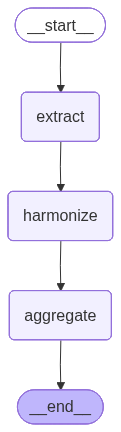

In [88]:
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(app.get_graph().draw_ascii())

In [109]:
current_state_input = {
  "master_taxonomy": [],
  "frequency_table": {},
  "current_batch": [],
  "current_date": ""
}

In [ ]:
# 1. Initialize the starting state (The Agent's Memory)
inputs = {
    "master_taxonomy": [],          # Starts empty, will grow each day
    "frequency_table": {},          # Will store {date: {topic: count}}
    "current_batch": [],            # Holds the current day's reviews
    "current_date": "",             # Holds the current date string
    "latest_extracted_topics": [],  # Temporary storage for the extractor
    "daily_mapping": {}             # Temporary storage for the harmonizer
}

# 2. Now run your loop (Limited to 3 days to test first!)
test_dates = sorted(all_data.keys())[:3]

for date_obj in test_dates:
    date_str = str(date_obj)
    print(f"\n>>> Processing Date: {date_str}")
    
    # We update the 'batch' and 'date' for the current loop iteration
    inputs["current_batch"] = all_data[date_obj]
    inputs["current_date"] = date_str
    
    # We run the graph and SAVE the output back into 'inputs'
    # This is how the taxonomy evolves!
    inputs = app.invoke(inputs)

print("\n--- Test Run Complete ---")


>>> Processing Date: 2024-06-01 00:00:00
✅ Success: Aggregated 29 mentions into 28 unique categories for 2024-06-01 00:00:00.

>>> Processing Date: 2024-06-02 00:00:00
✅ Success: Aggregated 51 mentions into 39 unique categories for 2024-06-02 00:00:00.

>>> Processing Date: 2024-06-03 00:00:00
✅ Success: Aggregated 15 mentions into 14 unique categories for 2024-06-03 00:00:00.

--- Test Run Complete ---


In [99]:
print("Master Taxonomy so far:", inputs["master_taxonomy"])
print("Frequency Table for first 3 days:", inputs["frequency_table"])

Master Taxonomy so far: ['Missing Items In Orders', 'Poor Customer Service', 'Incorrect Charges', 'App Logout Issue', 'Cash On Delivery Not Available', 'Untrustworthy Table Booking System', 'Delivery Partner Not Assigned', 'Cancellation Fee Despite Delays', 'Unresolved Issues After Multiple Complaints', 'Delivery Boy Behavior', 'App Crashes And Performance Issues', 'Delivery Delays', 'Unresponsive Customer Service', 'No Resolution From Customer Service', 'Late Delivery', 'Pathetic Customer Resolution.', 'Refund Issues', 'No Complaint Audit System.', 'Order Cancellation Policy', 'Incorrect Address Issues', 'Delivery Of Wrong Orders', 'Rain Charges', 'Order Delays', 'Long Delivery Times', 'Scammers In Swiggy', 'Coupons Disappearing', 'Poor Food Quality', 'Orders Getting Cancelled', 'Rubbish Hotel Listings', 'Non-Functional Restaurant Contact Numbers', 'Dog Food', 'Automatic Order Placement', 'Price Markup And Discount Issue', 'High Delivery Fees', 'High Delivery Charges For Short Distanc

In [110]:
# 1. Initialize the starting state (The Agent's Memory)
inputs = {
    "master_taxonomy": [],          # Starts empty, will grow each day
    "frequency_table": {},          # Will store {date: {topic: count}}
    "current_batch": [],            # Holds the current day's reviews
    "current_date": "",             # Holds the current date string
    "latest_extracted_topics": [],  # Temporary storage for the extractor
    "daily_mapping": {}             # Temporary storage for the harmonizer
}
# Re-run only first 3 days to verify it's clean now
test_dates = sorted(all_data.keys())[:3]

for date_obj in test_dates:
    date_str = str(date_obj)
    print(f"\n>>> Processing {date_str}...")
    inputs["current_batch"] = all_data[date_obj]
    inputs["current_date"] = date_str
    inputs = app.invoke(inputs)

# VERIFY THE OUTPUT
print("\n--- CLEANED TAXONOMY ---")
print(inputs["master_taxonomy"])
print("\n--- CLEANED TABLE KEYS ---")
first_date = str(test_dates[0])
print(list(inputs["frequency_table"][first_date].keys())[:10])


>>> Processing 2024-06-01 00:00:00...
✅ Success: Aggregated 102 mentions into 100 unique categories for 2024-06-01 00:00:00.

>>> Processing 2024-06-02 00:00:00...
✅ Success: Aggregated 119 mentions into 118 unique categories for 2024-06-02 00:00:00.

>>> Processing 2024-06-03 00:00:00...
✅ Success: Aggregated 112 mentions into 112 unique categories for 2024-06-03 00:00:00.

--- CLEANED TAXONOMY ---
['Missing Items In', 'Bad Quality.', 'Delivered Expired Product', 'Automated Support With', 'Bad Food Quality', 'Cancellation Charges', 'No One Picks', 'No Control Over', 'Pathetic Service And', 'No Cashback Received', 'Overpriced.', 'Always Late.', 'Worst Customer Service.', 'Terrible Customer Support', 'Delivery Issues', 'Broken Items And', 'Rotten Vegetables', 'Useless Orders And', 'Multiple Order Cancellations', 'No Resolution From', 'Poor Customer Service', 'App Crashes And', 'Misleading Rewards And', 'Changing Delivery Times', 'Service Degradation And', 'Untrustworthy Booking Service

In [111]:
# Check if the keys are now short and clean
first_date = list(inputs["frequency_table"].keys())[0]
print("Final Cleaned Keys:", list(inputs["frequency_table"][first_date].keys())[:10])

Final Cleaned Keys: ['The App That Lags The Most Cannot Meet Delivery Deadlines.', 'Worst Deliver Service Delivery Persons Never Carries Change.', 'Cancelled Prepaid Order Without Refund.', 'Fraud And Not Returning Refunds.', 'Sent Non-Veg Dish Instead Of Vegetarian.', 'Unprofessional Customer Support.', 'Taking Extra Amount.', 'Delivery Delay And No Compensation.', 'Changing Delivery Times And Suggesting To Cancel Or Reorder.', 'Automated Support With No Human Interaction.']
